In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import math
import matplotlib.pyplot as plt

# Установим random seeds для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# --- Гиперпараметры ---
IMAGE_SIZE = 64
PATCH_SIZE = 8
HIDDEN_DIM = 600
VIT_LAYERS = 6
VIT_HEADS = 6
BATCH_SIZE = 128
EPOCHS = 50
NUM_CLASSES = 100
IMAGE_SIZE = 64
BATCH_SIZE = 128
NUM_COMPONENTS = 8  # число компонент смеси в RNADE
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class ToRGB:
    def __call__(self, img):
        return img.convert('RGB')

class TinyImageNetTorch(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.data = hf_dataset
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        image = self.data[index]['image']
        label = self.data[index]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

def _filter_label_lt_num_classes(example):
    return int(example.get('label', -1)) < NUM_CLASSES

def get_dataset(split: str):
    def load_tinyimagenet(_split):
        dataset = load_dataset('zh-plus/tiny-imagenet', split=_split)
        dataset = dataset.filter(_filter_label_lt_num_classes)
        return dataset

    # Вычисляем статистики для нормализации
    train_raw = load_tinyimagenet('train')
    mean = torch.zeros(3)
    std = torch.zeros(3)
    n_samples = len(train_raw)
    for sample in train_raw:
        img = sample['image']
        img = transforms.ToTensor()(img)
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= n_samples
    std /= n_samples

    raw_dataset = load_tinyimagenet(split)
    if split == 'train':
        tfms = transforms.Compose([
            ToRGB(),
            transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ])
    else:
        tfms = transforms.Compose([
            ToRGB(),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ])
    return TinyImageNetTorch(raw_dataset, transform=tfms)

In [5]:
train_ds = get_dataset('train')
val_ds = get_dataset('valid')
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Проверка
print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}")
img, label = train_ds[0]
print(f"Image shape: {img.shape}, Label: {label}")

Train size: 50000, Val size: 5000
Image shape: torch.Size([3, 64, 64]), Label: 0


In [6]:
# --- ViT Backbone ---
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 4*hidden_dim), nn.GELU(), nn.Linear(4*hidden_dim, hidden_dim)
        )
        self.ln2 = nn.LayerNorm(hidden_dim)
    def forward(self, x, key_padding_mask=None):
        attn_out, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x = self.ln1(x + attn_out)
        x = self.ln2(x + self.ffn(x))
        return x

class ViTBackbone(nn.Module):
    def __init__(self, image_size, patch_size, hidden_dim, num_layers, num_heads):
        super().__init__()
        self.grid = image_size // patch_size
        self.num_patches = self.grid * self.grid
        self.hidden_dim = hidden_dim
        self.patch_embed = nn.Conv2d(3, hidden_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, hidden_dim))
        self.transformer_layers = nn.ModuleList([TransformerBlock(hidden_dim, num_heads) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(hidden_dim)
    def forward(self, x):
        t = self.patch_embed(x)                 # [B, D, g, g]
        t = t.flatten(2).transpose(1, 2)        # [B, T, D]
        t = t + self.pos_embed
        for blk in self.transformer_layers:
            t = blk(t)
        return self.norm(t)                     # [B, T, D]

In [7]:
# --- Student/Teacher ---
class Student(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
    def encode_context(self, x, context_mask):
        tokens = self.backbone.patch_embed(x).flatten(2).transpose(1, 2)
        pos = self.backbone.pos_embed
        ctx_lists, lengths = [], []
        for i in range(tokens.size(0)):
            idx = context_mask[i].nonzero(as_tuple=False).squeeze(1)
            ti = tokens[i, idx]
            pi = pos[0, idx]
            ctx_lists.append(ti + pi)
            lengths.append(int(idx.numel()))
        Sc = int(max(lengths)) if lengths else 0
        D = tokens.size(2)
        ctx_pad = torch.ones((x.size(0), Sc), dtype=torch.bool, device=x.device)
        ctx_out = torch.zeros((x.size(0), Sc, D), dtype=tokens.dtype, device=x.device)
        for i, ci in enumerate(ctx_lists):
            L = ci.size(0)
            ctx_out[i, :L] = ci
            ctx_pad[i, :L] = False
        for blk in self.backbone.transformer_layers:
            ctx_out = blk(ctx_out, key_padding_mask=ctx_pad)
        ctx_out = self.backbone.norm(ctx_out)
        return ctx_out, ctx_pad

class Teacher(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        for p in self.parameters():
            p.requires_grad = False
    @torch.no_grad()
    def forward(self, x):
        return self.backbone(x)
    @torch.no_grad()
    def ema_update(self, student, m):
        for p_t, p_s in zip(self.backbone.parameters(), student.backbone.parameters()):
            p_t.data.mul_(m).add_(p_s.data, alpha=(1.0 - m))

In [8]:
# Маскируемый линейный слой для MADE
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, mask, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', mask)

    def forward(self, input):
        return torch.nn.functional.linear(input, self.weight * self.mask, self.bias)


# Функция для генерации масок в MADE
def create_masks(input_dim, hidden_dims, num_components):
    """
    Генерирует бинарные маски для авторегрессионного MLP (MADE).
    """
    D = input_dim
    layers = [D] + hidden_dims + [D * num_components * 3]

    # Порождаем "ранги соединений" (порядок зависимостей между входами)
    rng = torch.Generator().manual_seed(0)

    degrees = []
    for i, layer_dim in enumerate(layers):
        if i == 0:
            degrees.append(torch.arange(1, D + 1))
        else:
            # Случайным образом присваиваем каждому нейрону степень зависимости
            min_degree = torch.min(degrees[-1]).item()
            degrees.append(
                torch.randint(min_degree, D + 1, (layer_dim,), generator=rng)
            )

    # Теперь создаём маски для всех линейных слоёв
    masks = []
    for i in range(len(layers) - 1):
        mask = (degrees[i + 1].unsqueeze(-1) >= degrees[i].unsqueeze(0)).float()
        masks.append(mask)

    return masks


In [9]:
class MaskedAutoregressiveMLPConditional(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_components, context_dim):
        super().__init__()
        self.input_dim = input_dim
        self.num_components = num_components
        self.context_dim = context_dim
        
        # Создаём маски для авторегрессивной части (как раньше)
        masks = create_masks(input_dim, hidden_dims, num_components)
        
        # FiLM-модуляция: контекст → масштаб/сдвиг для каждого скрытого слоя
        self.net = nn.ModuleList()
        self.hidden_acts = nn.ModuleList([nn.ReLU() for _ in hidden_dims])
        self.film_scale = nn.ModuleList()
        self.film_shift = nn.ModuleList()
        
        dims = [input_dim] + hidden_dims + [input_dim * num_components * 3]
        for i in range(len(dims) - 1):
            self.net.append(MaskedLinear(dims[i], dims[i+1], masks[i]))
            if i < len(hidden_dims):  # FiLM только для скрытых слоёв
                self.film_scale.append(nn.Linear(context_dim, dims[i+1]))
                self.film_shift.append(nn.Linear(context_dim, dims[i+1]))
        
    def forward(self, x, context):
        """
        x: (B, D) — авторегрессивный вход (целевые токены)
        context: (B, context_dim) — агрегированное представление контекста студента
        """
        h = x
        for i, layer in enumerate(self.net[:-1]):
            h = layer(h)
            # FiLM-модуляция
            scale = self.film_scale[i](context)
            shift = self.film_shift[i](context)
            h = h * (1 + scale) + shift
            h = self.hidden_acts[i](h)
        
        out = self.net[-1](h)  # (B, D * K * 3)
        D, K = self.input_dim, self.num_components
        out = out.view(-1, D, K, 3)
        
        alpha = F.softmax(out[..., 0], dim=-1)  # (B, D, K)
        mu = out[..., 1]
        # Ограничиваем сигму снизу и сверху для стабильности
        log_sigma = torch.clamp(out[..., 2], min=-7, max=7)
        sigma = F.softplus(log_sigma) + 1e-3  
        
        return alpha, mu, sigma


In [10]:
# --- Маскирование ---
def _sample_blocks(grid, n_blocks, scale, ar):
    blocks = []
    for _ in range(n_blocks):
        area = np.random.uniform(scale[0], scale[1]) * (grid * grid)
        r = np.random.uniform(ar[0], ar[1])
        h = int(round(np.sqrt(area / r)))
        w = int(round(h * r))
        h = max(1, min(h, grid))
        w = max(1, min(w, grid))
        y0 = np.random.randint(0, max(1, grid - h + 1))
        x0 = np.random.randint(0, max(1, grid - w + 1))
        blocks.append((y0, x0, h, w))
    return blocks

def build_mask_from_blocks(grid, blocks):
    mask = torch.zeros(grid, grid, dtype=torch.bool)
    for (y0, x0, h, w) in blocks:
        mask[y0:y0 + h, x0:x0 + w] = True
    return mask.flatten()

def sample_context_and_targets(grid, min_ctx=8, max_tries=50):
    for _ in range(max_tries):
        ctx_block = _sample_blocks(grid, 1, (0.85, 1.0), (0.75, 1.5))[0]
        tgt_blocks = _sample_blocks(grid, 4, (0.15, 0.20), (0.75, 1.5))
        ctx = torch.zeros(grid, grid, dtype=torch.bool)
        y0, x0, h, w = ctx_block
        ctx[y0:y0 + h, x0:x0 + w] = True
        tgt = torch.zeros(grid, grid, dtype=torch.bool)
        for (yy, xx, hh, ww) in tgt_blocks:
            tgt[yy:yy + hh, xx:xx + ww] = True
        ctx[tgt] = False
        if int(ctx.sum().item()) >= min_ctx and int(tgt.sum().item()) > 0:
            return ctx.flatten(), tgt.flatten()
    ctx = torch.ones(grid, grid, dtype=torch.bool)
    tgt_blocks = _sample_blocks(grid, 2, (0.10, 0.15), (0.75, 1.5))
    tgt = torch.zeros(grid, grid, dtype=torch.bool)
    for (yy, xx, hh, ww) in tgt_blocks:
        tgt[yy:yy + hh, xx:xx + ww] = True
    ctx[tgt] = False
    if int(ctx.sum().item()) == 0:
        ctx[0, 0] = True; tgt[0, 0] = False
    return ctx.flatten(), tgt.flatten()

In [11]:
# --- NLL Loss для смеси Гауссиан ---
def mixture_gaussian_nll_loss(target, alpha, mu, sigma):
    """
    target: (B, D)
    alpha, mu, sigma: (B, D, K)
    """
    B, D = target.shape
    K = alpha.shape[-1]
    
    target = target.unsqueeze(-1)  # (B, D, 1)
    
    # Стабильная форма: -log(sigma) - 0.5 * log(2π) вместо log(sigma^2)
    log_prob = (
        -torch.log(sigma + 1e-8)
        - 0.5 * math.log(2 * math.pi)
        - 0.5 * ((target - mu) / (sigma + 1e-8))**2
    )  # (B, D, K)
    
    # Взвешенная смесь
    log_prob = torch.log(alpha + 1e-8) + log_prob
    log_prob = torch.logsumexp(log_prob, dim=-1)  # (B, D)
    
    nll = -log_prob.mean()
    return nll

In [12]:
# --- kNN Validation ---
@torch.no_grad()
def extract_global_embeddings(backbone, loader, device):
    backbone.eval()
    feats, labels = [], []
    for x, y in loader:
        x = x.to(device)
        t = backbone(x)
        g = t.mean(dim=1)
        feats.append(g.cpu())
        labels.append(y.clone().cpu())
    return torch.cat(feats, dim=0), torch.cat(labels, dim=0)

@torch.no_grad()
def knn_eval(train_feats, train_labels, val_feats, val_labels, k=20):
    train_norm = F.normalize(train_feats, dim=1)
    val_norm = F.normalize(val_feats, dim=1)
    sim = val_norm @ train_norm.t()
    topk = sim.topk(k, dim=1).indices
    neighbors = train_labels[topk]
    preds = torch.mode(neighbors, dim=1).values
    acc = (preds == val_labels).float().mean().item()
    return float(acc)

In [13]:
def eval_loss_on_loader(loader):
    student.eval()
    predictor.eval()
    batch_losses = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(DEVICE)
            B = x.size(0)
            grid = student.backbone.grid
            ctx_list, tgt_list = [], []
            for b in range(B):
                ctx_mask, tgt_mask = sample_context_and_targets(grid)
                ctx_list.append(ctx_mask)
                tgt_list.append(tgt_mask)
            context_mask = torch.stack(ctx_list, dim=0).to(x.device)
            target_mask = torch.stack(tgt_list, dim=0).to(x.device)
            ctx_out, ctx_pad = student.encode_context(x, context_mask)
            ctx_mask_float = (~ctx_pad).float().unsqueeze(-1)
            ctx_sum = (ctx_out * ctx_mask_float).sum(dim=1)
            ctx_count = ctx_mask_float.sum(dim=1).clamp(min=1)
            ctx_feat = ctx_sum / ctx_count
            t_tokens = teacher(x)
            tgt_idxs = [target_mask[i].nonzero(as_tuple=False).squeeze(1) for i in range(B)]
            St = int(max([int(idx.numel()) for idx in tgt_idxs]) if tgt_idxs else 0)
            D = t_tokens.size(2)
            teacher_tgt = torch.zeros(B, St, D, device=x.device, dtype=t_tokens.dtype)
            tgt_pad = torch.ones(B, St, dtype=torch.bool, device=x.device)
            for i, idx in enumerate(tgt_idxs):
                L = int(idx.numel())
                if L == 0: continue
                teacher_tgt[i, :L] = t_tokens[i, idx]
                tgt_pad[i, :L] = False
            teacher_tgt_flat = teacher_tgt[~tgt_pad].view(-1, D)
            mean_tgt = teacher_tgt_flat.mean(dim=0, keepdim=True)
            std_tgt = teacher_tgt_flat.std(dim=0, keepdim=True) + 1e-6
            teacher_tgt_flat = (teacher_tgt_flat - mean_tgt) / std_tgt
            ctx_feat_expanded = ctx_feat.unsqueeze(1).expand(B, St, -1).reshape(B * St, -1)[~tgt_pad.view(-1)]
            alpha, mu, sigma = predictor(teacher_tgt_flat, ctx_feat_expanded)
            loss = mixture_gaussian_nll_loss(teacher_tgt_flat, alpha, mu, sigma)
            log_sigma_mean = torch.log(sigma + 1e-8).mean()
            sigma_reg = 0.01 * (log_sigma_mean - math.log(0.1))**2
            total_loss = loss + sigma_reg
            batch_losses.append(total_loss.item())
    return batch_losses

In [14]:
student = Student(ViTBackbone(IMAGE_SIZE, PATCH_SIZE, HIDDEN_DIM, VIT_LAYERS, VIT_HEADS)).to(DEVICE)
teacher = Teacher(ViTBackbone(IMAGE_SIZE, PATCH_SIZE, HIDDEN_DIM, VIT_LAYERS, VIT_HEADS)).to(DEVICE)
teacher.ema_update(student, m=0.0)
predictor = MaskedAutoregressiveMLPConditional(
    input_dim=HIDDEN_DIM,        
    hidden_dims=[1024, 768, 512],
    num_components=NUM_COMPONENTS,             
    context_dim=HIDDEN_DIM        
).to(DEVICE)
opt = torch.optim.AdamW(list(student.parameters()) + list(predictor.parameters()), lr=2e-4, weight_decay=1e-3)

Epoch 1:   0%|          | 1/391 [00:01<10:45,  1.66s/it]

Epoch 1 Batch 0 Loss:1.6134


Epoch 1:  13%|█▎        | 51/391 [00:27<02:56,  1.92it/s]

Epoch 1 Batch 50 Loss:1.1177


Epoch 1:  26%|██▌       | 101/391 [00:54<02:33,  1.89it/s]

Epoch 1 Batch 100 Loss:0.5409


Epoch 1:  39%|███▊      | 151/391 [01:20<02:18,  1.74it/s]

Epoch 1 Batch 150 Loss:0.2124


Epoch 1:  51%|█████▏    | 201/391 [01:46<01:40,  1.90it/s]

Epoch 1 Batch 200 Loss:-0.0969


Epoch 1:  64%|██████▍   | 251/391 [02:13<01:14,  1.87it/s]

Epoch 1 Batch 250 Loss:-0.3372


Epoch 1:  77%|███████▋  | 301/391 [02:39<00:47,  1.88it/s]

Epoch 1 Batch 300 Loss:-0.2783


Epoch 1:  90%|████████▉ | 351/391 [03:05<00:20,  1.92it/s]

Epoch 1 Batch 350 Loss:-0.4751


Epoch 1: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


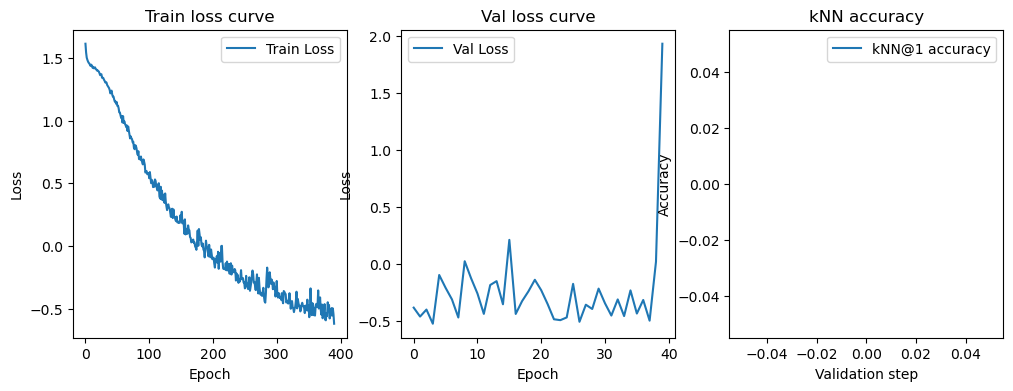

Epoch 2:   0%|          | 1/391 [00:01<08:46,  1.35s/it]

Epoch 2 Batch 0 Loss:-0.4730


Epoch 2:  13%|█▎        | 51/391 [00:27<02:58,  1.90it/s]

Epoch 2 Batch 50 Loss:-0.5865


Epoch 2:  26%|██▌       | 101/391 [00:53<02:32,  1.91it/s]

Epoch 2 Batch 100 Loss:-0.6562


Epoch 2:  39%|███▊      | 151/391 [01:20<02:06,  1.90it/s]

Epoch 2 Batch 150 Loss:-0.5671


Epoch 2:  51%|█████▏    | 201/391 [01:46<01:39,  1.91it/s]

Epoch 2 Batch 200 Loss:-0.5300


Epoch 2:  64%|██████▍   | 251/391 [02:12<01:12,  1.93it/s]

Epoch 2 Batch 250 Loss:-0.5988


Epoch 2:  77%|███████▋  | 301/391 [02:38<00:46,  1.94it/s]

Epoch 2 Batch 300 Loss:-0.6643


Epoch 2:  90%|████████▉ | 351/391 [03:05<00:21,  1.88it/s]

Epoch 2 Batch 350 Loss:-0.6216


Epoch 2: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]


Validation kNN...
Epoch 2 kNN@1 accuracy: 4.40%


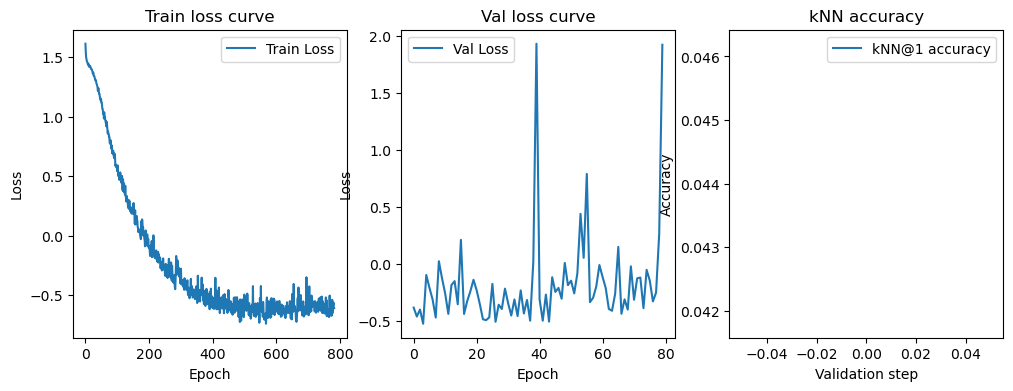

Epoch 3:   0%|          | 1/391 [00:01<09:21,  1.44s/it]

Epoch 3 Batch 0 Loss:-0.5920


Epoch 3:  13%|█▎        | 51/391 [00:27<03:00,  1.88it/s]

Epoch 3 Batch 50 Loss:-0.5938


Epoch 3:  26%|██▌       | 101/391 [00:54<02:29,  1.93it/s]

Epoch 3 Batch 100 Loss:-0.5754


Epoch 3:  39%|███▊      | 151/391 [01:20<02:09,  1.86it/s]

Epoch 3 Batch 150 Loss:-0.6029


Epoch 3:  51%|█████▏    | 201/391 [01:46<01:40,  1.89it/s]

Epoch 3 Batch 200 Loss:-0.5599


Epoch 3:  64%|██████▍   | 251/391 [02:12<01:12,  1.93it/s]

Epoch 3 Batch 250 Loss:-0.5814


Epoch 3:  77%|███████▋  | 301/391 [02:39<00:47,  1.88it/s]

Epoch 3 Batch 300 Loss:-0.6116


Epoch 3:  90%|████████▉ | 351/391 [03:05<00:21,  1.89it/s]

Epoch 3 Batch 350 Loss:-0.5044


Epoch 3: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


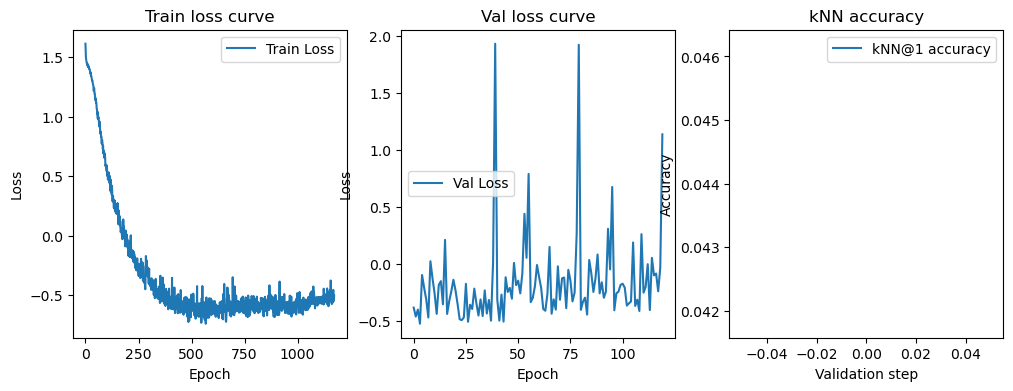

Epoch 4:   0%|          | 1/391 [00:01<09:08,  1.41s/it]

Epoch 4 Batch 0 Loss:-0.5241


Epoch 4:  13%|█▎        | 51/391 [00:27<03:01,  1.88it/s]

Epoch 4 Batch 50 Loss:-0.4804


Epoch 4:  26%|██▌       | 101/391 [00:54<02:31,  1.92it/s]

Epoch 4 Batch 100 Loss:-0.4032


Epoch 4:  39%|███▊      | 151/391 [01:20<02:08,  1.87it/s]

Epoch 4 Batch 150 Loss:-0.4697


Epoch 4:  51%|█████▏    | 201/391 [01:46<01:39,  1.90it/s]

Epoch 4 Batch 200 Loss:-0.3580


Epoch 4:  64%|██████▍   | 251/391 [02:12<01:13,  1.91it/s]

Epoch 4 Batch 250 Loss:-0.3628


Epoch 4:  77%|███████▋  | 301/391 [02:39<00:48,  1.86it/s]

Epoch 4 Batch 300 Loss:-0.3512


Epoch 4:  90%|████████▉ | 351/391 [03:05<00:21,  1.90it/s]

Epoch 4 Batch 350 Loss:-0.3065


Epoch 4: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


Validation kNN...
Epoch 4 kNN@1 accuracy: 5.42%


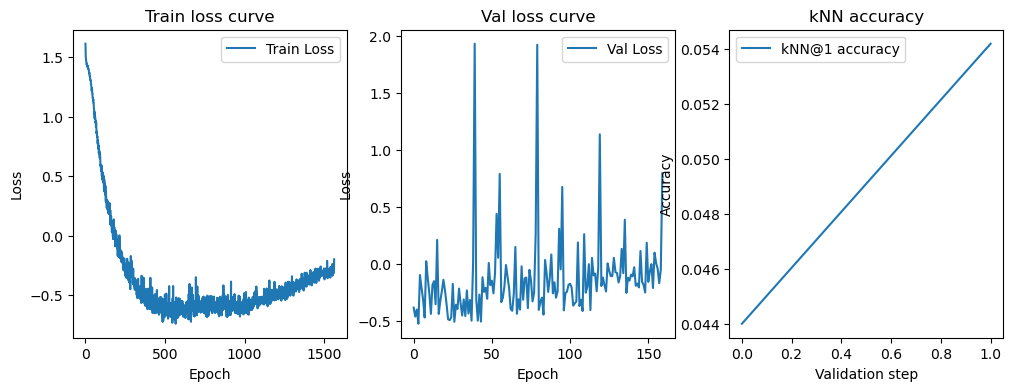

Epoch 5:   0%|          | 1/391 [00:01<08:00,  1.23s/it]

Epoch 5 Batch 0 Loss:-0.3172


Epoch 5:  13%|█▎        | 51/391 [00:27<02:59,  1.89it/s]

Epoch 5 Batch 50 Loss:-0.2779


Epoch 5:  26%|██▌       | 101/391 [00:53<02:33,  1.89it/s]

Epoch 5 Batch 100 Loss:-0.2892


Epoch 5:  39%|███▊      | 151/391 [01:20<02:09,  1.86it/s]

Epoch 5 Batch 150 Loss:-0.2554


Epoch 5:  51%|█████▏    | 201/391 [01:46<01:40,  1.89it/s]

Epoch 5 Batch 200 Loss:-0.2631


Epoch 5:  64%|██████▍   | 251/391 [02:12<01:13,  1.90it/s]

Epoch 5 Batch 250 Loss:-0.2059


Epoch 5:  77%|███████▋  | 301/391 [02:38<00:47,  1.90it/s]

Epoch 5 Batch 300 Loss:-0.2339


Epoch 5:  90%|████████▉ | 351/391 [03:05<00:20,  1.91it/s]

Epoch 5 Batch 350 Loss:-0.1870


Epoch 5: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]


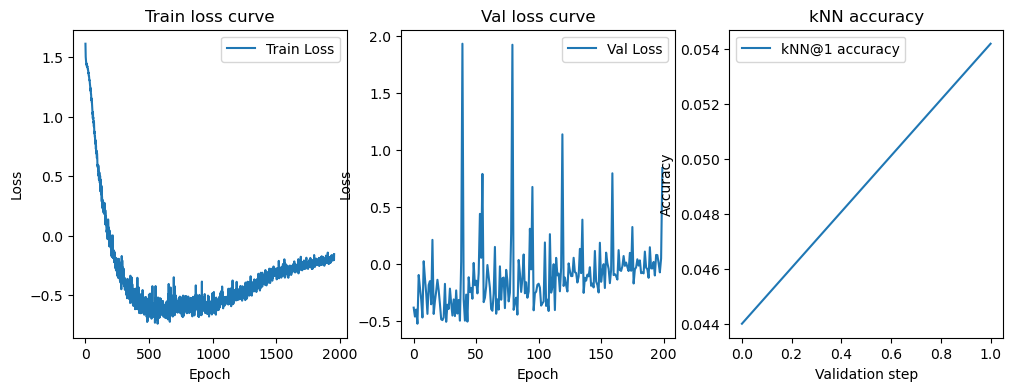

Epoch 6:   0%|          | 1/391 [00:01<08:40,  1.33s/it]

Epoch 6 Batch 0 Loss:-0.1703


Epoch 6:  13%|█▎        | 51/391 [00:27<02:59,  1.89it/s]

Epoch 6 Batch 50 Loss:-0.1685


Epoch 6:  26%|██▌       | 101/391 [00:53<02:31,  1.92it/s]

Epoch 6 Batch 100 Loss:-0.1502


Epoch 6:  39%|███▊      | 151/391 [01:20<02:06,  1.89it/s]

Epoch 6 Batch 150 Loss:-0.1426


Epoch 6:  51%|█████▏    | 201/391 [01:46<01:38,  1.92it/s]

Epoch 6 Batch 200 Loss:-0.1175


Epoch 6:  64%|██████▍   | 251/391 [02:12<01:14,  1.88it/s]

Epoch 6 Batch 250 Loss:-0.0660


Epoch 6:  77%|███████▋  | 301/391 [02:39<00:47,  1.88it/s]

Epoch 6 Batch 300 Loss:-0.0730


Epoch 6:  90%|████████▉ | 351/391 [03:05<00:21,  1.90it/s]

Epoch 6 Batch 350 Loss:-0.1128


Epoch 6: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


Validation kNN...
Epoch 6 kNN@1 accuracy: 6.44%


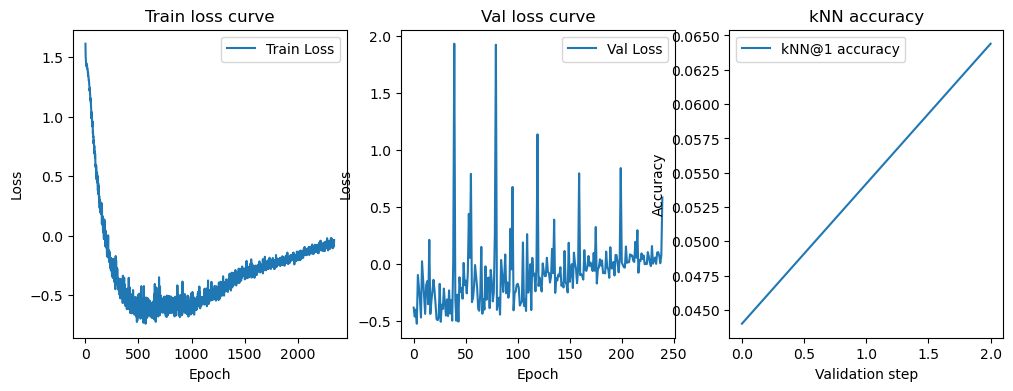

Epoch 7:   0%|          | 1/391 [00:01<07:50,  1.21s/it]

Epoch 7 Batch 0 Loss:-0.0788


Epoch 7:  13%|█▎        | 51/391 [00:27<02:59,  1.89it/s]

Epoch 7 Batch 50 Loss:-0.0676


Epoch 7:  26%|██▌       | 101/391 [00:53<02:32,  1.90it/s]

Epoch 7 Batch 100 Loss:-0.0390


Epoch 7:  39%|███▊      | 151/391 [01:20<02:04,  1.93it/s]

Epoch 7 Batch 150 Loss:-0.0346


Epoch 7:  51%|█████▏    | 201/391 [01:46<01:39,  1.90it/s]

Epoch 7 Batch 200 Loss:-0.0272


Epoch 7:  64%|██████▍   | 251/391 [02:12<01:13,  1.91it/s]

Epoch 7 Batch 250 Loss:-0.0133


Epoch 7:  77%|███████▋  | 301/391 [02:38<00:46,  1.93it/s]

Epoch 7 Batch 300 Loss:-0.0098


Epoch 7:  90%|████████▉ | 351/391 [03:04<00:20,  1.91it/s]

Epoch 7 Batch 350 Loss:-0.0033


Epoch 7: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]


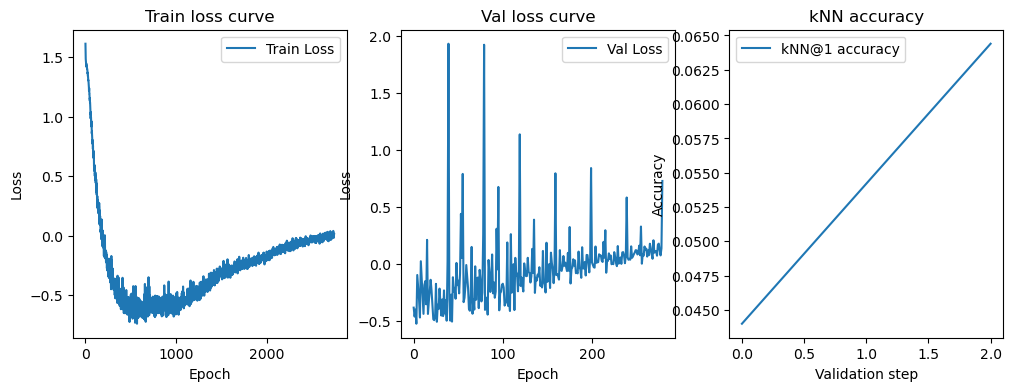

Epoch 8:   0%|          | 1/391 [00:01<09:26,  1.45s/it]

Epoch 8 Batch 0 Loss:-0.0215


Epoch 8:  13%|█▎        | 51/391 [00:27<02:58,  1.90it/s]

Epoch 8 Batch 50 Loss:0.0348


Epoch 8:  26%|██▌       | 101/391 [00:54<02:35,  1.86it/s]

Epoch 8 Batch 100 Loss:0.0026


Epoch 8:  39%|███▊      | 151/391 [01:20<02:05,  1.91it/s]

Epoch 8 Batch 150 Loss:0.0052


Epoch 8:  51%|█████▏    | 201/391 [01:46<01:39,  1.91it/s]

Epoch 8 Batch 200 Loss:0.0386


Epoch 8:  64%|██████▍   | 251/391 [02:13<01:13,  1.90it/s]

Epoch 8 Batch 250 Loss:0.0300


Epoch 8:  77%|███████▋  | 301/391 [02:39<00:47,  1.91it/s]

Epoch 8 Batch 300 Loss:0.0195


Epoch 8:  90%|████████▉ | 351/391 [03:06<00:21,  1.90it/s]

Epoch 8 Batch 350 Loss:0.0204


Epoch 9:  13%|█▎        | 51/391 [00:27<02:57,  1.91it/s]]

Epoch 9 Batch 50 Loss:0.0226


Epoch 9:  26%|██▌       | 101/391 [00:54<02:35,  1.86it/s]

Epoch 9 Batch 100 Loss:-0.0017


Epoch 9:  39%|███▊      | 151/391 [01:20<02:09,  1.86it/s]

Epoch 9 Batch 150 Loss:0.0226


Epoch 9:  51%|█████▏    | 201/391 [01:47<01:40,  1.90it/s]

Epoch 9 Batch 200 Loss:0.0027


Epoch 9:  64%|██████▍   | 251/391 [02:13<01:14,  1.87it/s]

Epoch 9 Batch 250 Loss:0.0347


Epoch 9:  77%|███████▋  | 301/391 [02:40<00:47,  1.90it/s]

Epoch 9 Batch 300 Loss:0.0571


Epoch 9:  90%|████████▉ | 351/391 [03:06<00:20,  1.92it/s]

Epoch 9 Batch 350 Loss:0.0033


Epoch 9: 100%|██████████| 391/391 [03:27<00:00,  1.88it/s]


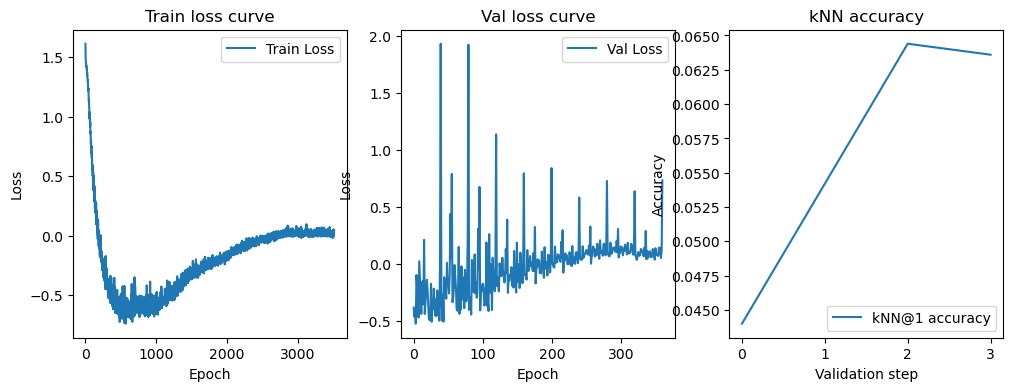

Epoch 10:   0%|          | 1/391 [00:01<08:05,  1.25s/it]

Epoch 10 Batch 0 Loss:0.0284


Epoch 10:  13%|█▎        | 51/391 [00:27<03:01,  1.88it/s]

Epoch 10 Batch 50 Loss:0.0365


Epoch 10:  26%|██▌       | 101/391 [00:53<02:33,  1.89it/s]

Epoch 10 Batch 100 Loss:0.0111


Epoch 10:  39%|███▊      | 151/391 [01:20<02:04,  1.92it/s]

Epoch 10 Batch 150 Loss:0.0106


Epoch 10:  51%|█████▏    | 201/391 [01:46<01:39,  1.91it/s]

Epoch 10 Batch 200 Loss:0.0164


Epoch 10:  64%|██████▍   | 251/391 [02:12<01:12,  1.92it/s]

Epoch 10 Batch 250 Loss:0.0057


Epoch 10:  77%|███████▋  | 301/391 [02:39<00:47,  1.88it/s]

Epoch 10 Batch 300 Loss:0.0109


Epoch 10:  90%|████████▉ | 351/391 [03:05<00:21,  1.89it/s]

Epoch 10 Batch 350 Loss:-0.0149


Epoch 10: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


Validation kNN...
Epoch 10 kNN@1 accuracy: 6.52%


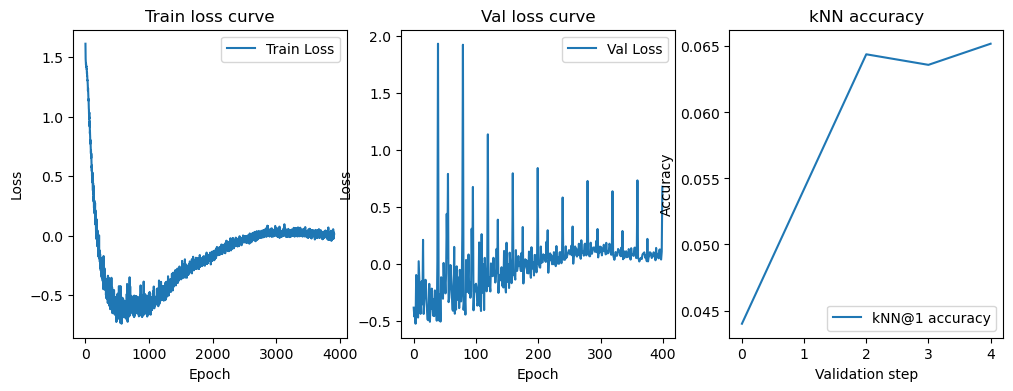

Epoch 11:   0%|          | 1/391 [00:01<08:44,  1.35s/it]

Epoch 11 Batch 0 Loss:0.0121


Epoch 11:  13%|█▎        | 51/391 [00:27<02:57,  1.92it/s]

Epoch 11 Batch 50 Loss:0.0092


Epoch 11:  26%|██▌       | 101/391 [00:53<02:31,  1.91it/s]

Epoch 11 Batch 100 Loss:-0.0173


Epoch 11:  39%|███▊      | 151/391 [01:20<02:05,  1.91it/s]

Epoch 11 Batch 150 Loss:-0.0051


Epoch 11:  51%|█████▏    | 201/391 [01:46<01:39,  1.91it/s]

Epoch 11 Batch 200 Loss:0.0100


Epoch 11:  64%|██████▍   | 251/391 [02:12<01:14,  1.89it/s]

Epoch 11 Batch 250 Loss:-0.0130


Epoch 11:  77%|███████▋  | 301/391 [02:38<00:47,  1.91it/s]

Epoch 11 Batch 300 Loss:-0.0294


Epoch 11:  90%|████████▉ | 351/391 [03:05<00:21,  1.89it/s]

Epoch 11 Batch 350 Loss:-0.0127


Epoch 11: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]


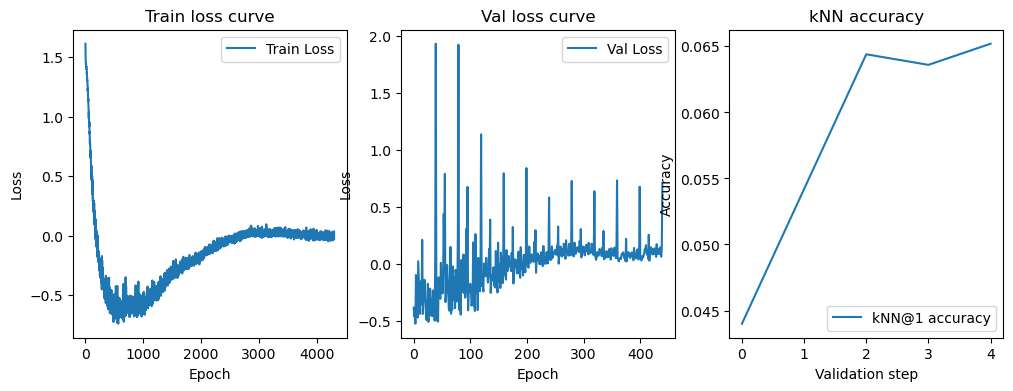

Epoch 12:   0%|          | 1/391 [00:01<08:52,  1.37s/it]

Epoch 12 Batch 0 Loss:0.0186


Epoch 12:  13%|█▎        | 51/391 [00:27<02:58,  1.91it/s]

Epoch 12 Batch 50 Loss:0.0104


Epoch 12:  26%|██▌       | 101/391 [00:54<02:31,  1.91it/s]

Epoch 12 Batch 100 Loss:0.0124


Epoch 12:  39%|███▊      | 151/391 [01:20<02:05,  1.91it/s]

Epoch 12 Batch 150 Loss:-0.0179


Epoch 12:  51%|█████▏    | 201/391 [01:46<01:41,  1.87it/s]

Epoch 12 Batch 200 Loss:-0.0148


Epoch 12:  64%|██████▍   | 251/391 [02:13<01:14,  1.89it/s]

Epoch 12 Batch 250 Loss:-0.0429


Epoch 12:  77%|███████▋  | 301/391 [02:39<00:46,  1.93it/s]

Epoch 12 Batch 300 Loss:-0.0126


Epoch 12:  90%|████████▉ | 351/391 [03:05<00:20,  1.93it/s]

Epoch 12 Batch 350 Loss:-0.0311


Epoch 12: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


Validation kNN...
Epoch 12 kNN@1 accuracy: 6.76%


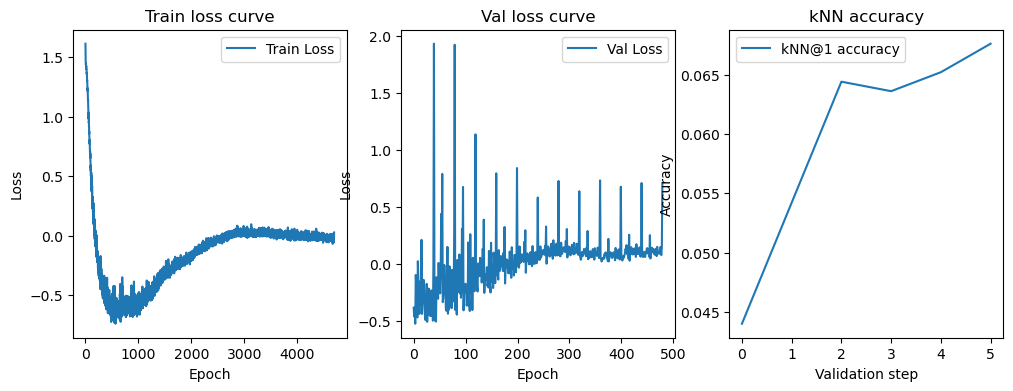

Epoch 13:   0%|          | 1/391 [00:01<08:32,  1.31s/it]

Epoch 13 Batch 0 Loss:0.0432


Epoch 13:  13%|█▎        | 51/391 [00:27<02:57,  1.91it/s]

Epoch 13 Batch 50 Loss:-0.0218


Epoch 13:  26%|██▌       | 101/391 [00:53<02:30,  1.92it/s]

Epoch 13 Batch 100 Loss:-0.0397


Epoch 13:  39%|███▊      | 151/391 [01:20<02:05,  1.91it/s]

Epoch 13 Batch 150 Loss:-0.0282


Epoch 13:  51%|█████▏    | 201/391 [01:46<01:40,  1.90it/s]

Epoch 13 Batch 200 Loss:-0.0758


Epoch 13:  64%|██████▍   | 251/391 [02:12<01:12,  1.94it/s]

Epoch 13 Batch 250 Loss:-0.0535


Epoch 13:  77%|███████▋  | 301/391 [02:39<00:46,  1.94it/s]

Epoch 13 Batch 300 Loss:-0.0550


Epoch 13:  90%|████████▉ | 351/391 [03:05<00:20,  1.91it/s]

Epoch 13 Batch 350 Loss:-0.0671


Epoch 13: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


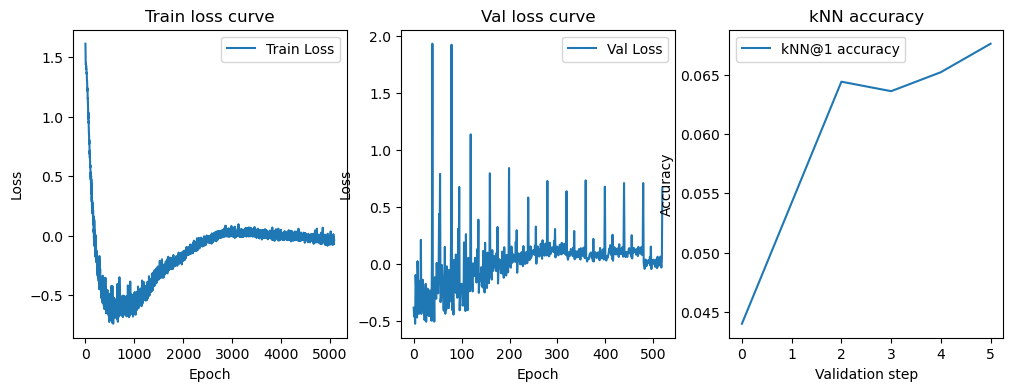

Epoch 14:   0%|          | 1/391 [00:01<09:08,  1.41s/it]

Epoch 14 Batch 0 Loss:-0.0616


Epoch 14:  13%|█▎        | 51/391 [00:27<02:57,  1.92it/s]

Epoch 14 Batch 50 Loss:-0.0427


Epoch 14:  26%|██▌       | 101/391 [00:53<02:32,  1.90it/s]

Epoch 14 Batch 100 Loss:-0.0057


Epoch 14:  39%|███▊      | 151/391 [01:20<02:05,  1.91it/s]

Epoch 14 Batch 150 Loss:-0.0418


Epoch 14:  51%|█████▏    | 201/391 [01:46<01:38,  1.93it/s]

Epoch 14 Batch 200 Loss:-0.0178


Epoch 14:  64%|██████▍   | 251/391 [02:12<01:12,  1.93it/s]

Epoch 14 Batch 250 Loss:-0.0489


Epoch 14:  77%|███████▋  | 301/391 [02:39<00:48,  1.86it/s]

Epoch 14 Batch 300 Loss:-0.0412


Epoch 14:  90%|████████▉ | 351/391 [03:05<00:20,  1.93it/s]

Epoch 14 Batch 350 Loss:-0.0532


Epoch 14: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


Validation kNN...
Epoch 14 kNN@1 accuracy: 7.64%


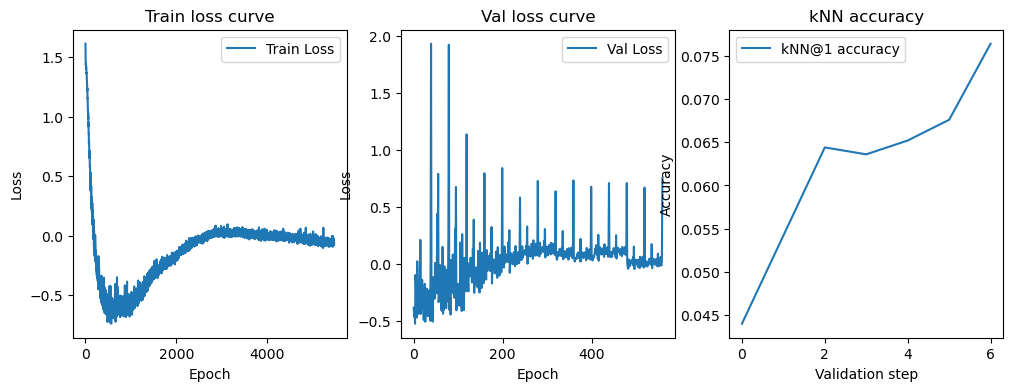

Epoch 15:   0%|          | 1/391 [00:01<08:55,  1.37s/it]

Epoch 15 Batch 0 Loss:-0.0580


Epoch 15:  13%|█▎        | 51/391 [00:27<02:56,  1.93it/s]

Epoch 15 Batch 50 Loss:-0.0619


Epoch 15:  26%|██▌       | 101/391 [00:53<02:33,  1.89it/s]

Epoch 15 Batch 100 Loss:-0.0527


Epoch 15:  39%|███▊      | 151/391 [01:19<02:04,  1.92it/s]

Epoch 15 Batch 150 Loss:-0.0836


Epoch 15:  51%|█████▏    | 201/391 [01:45<01:40,  1.90it/s]

Epoch 15 Batch 200 Loss:-0.0873


Epoch 15:  64%|██████▍   | 251/391 [02:12<01:11,  1.95it/s]

Epoch 15 Batch 250 Loss:-0.1163


Epoch 15:  77%|███████▋  | 301/391 [02:38<00:46,  1.92it/s]

Epoch 15 Batch 300 Loss:-0.0774


Epoch 15:  90%|████████▉ | 351/391 [03:04<00:20,  1.92it/s]

Epoch 15 Batch 350 Loss:-0.0659


Epoch 15: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]


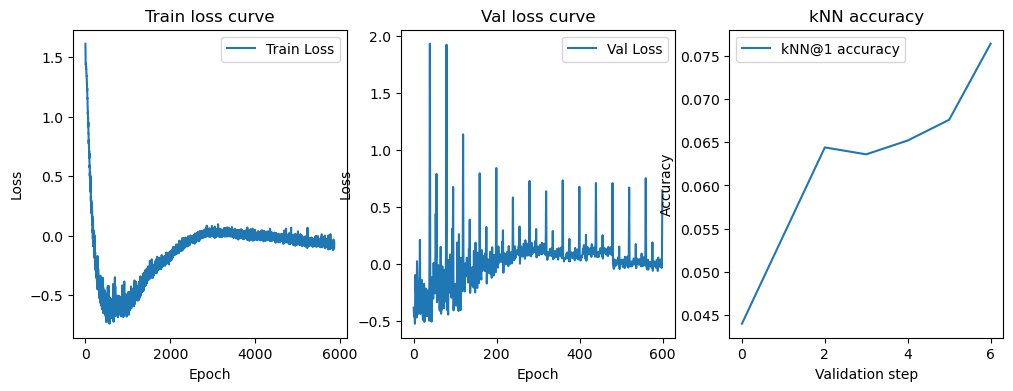

Epoch 16:   0%|          | 1/391 [00:01<08:33,  1.32s/it]

Epoch 16 Batch 0 Loss:-0.0542


Epoch 16:  13%|█▎        | 51/391 [00:27<02:59,  1.90it/s]

Epoch 16 Batch 50 Loss:-0.0813


Epoch 16:  26%|██▌       | 101/391 [00:54<02:34,  1.87it/s]

Epoch 16 Batch 100 Loss:-0.0927


Epoch 16:  39%|███▊      | 151/391 [01:20<02:08,  1.87it/s]

Epoch 16 Batch 150 Loss:-0.0980


Epoch 16:  51%|█████▏    | 201/391 [01:46<01:42,  1.86it/s]

Epoch 16 Batch 200 Loss:-0.0987


Epoch 16:  64%|██████▍   | 251/391 [02:12<01:14,  1.88it/s]

Epoch 16 Batch 250 Loss:-0.0847


Epoch 16:  77%|███████▋  | 301/391 [02:39<00:46,  1.92it/s]

Epoch 16 Batch 300 Loss:-0.1235


Epoch 16:  90%|████████▉ | 351/391 [03:05<00:21,  1.87it/s]

Epoch 16 Batch 350 Loss:-0.0935


Epoch 16: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]


Validation kNN...
Epoch 16 kNN@1 accuracy: 8.00%


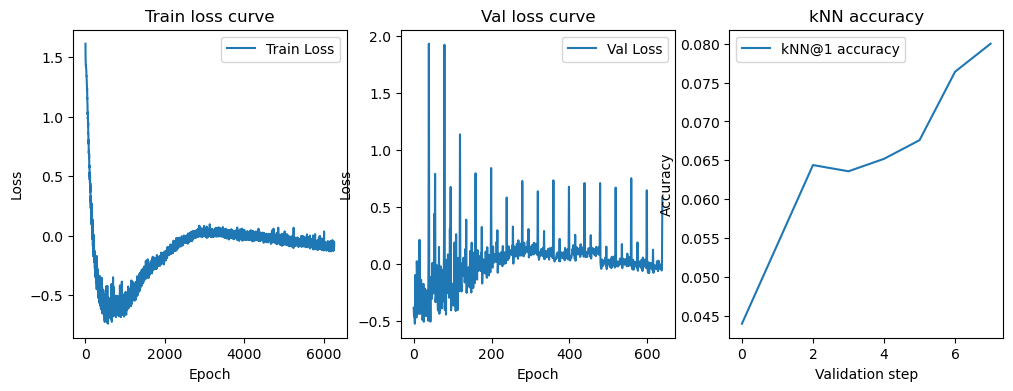

Epoch 17:   0%|          | 1/391 [00:01<09:19,  1.43s/it]

Epoch 17 Batch 0 Loss:-0.0949


Epoch 17:  13%|█▎        | 51/391 [00:27<02:58,  1.91it/s]

Epoch 17 Batch 50 Loss:-0.1047


Epoch 17:  26%|██▌       | 101/391 [00:53<02:32,  1.90it/s]

Epoch 17 Batch 100 Loss:-0.1131


Epoch 17:  39%|███▊      | 151/391 [01:20<02:05,  1.92it/s]

Epoch 17 Batch 150 Loss:-0.0700


Epoch 17:  51%|█████▏    | 201/391 [01:46<01:38,  1.94it/s]

Epoch 17 Batch 200 Loss:-0.1225


Epoch 17:  64%|██████▍   | 251/391 [02:12<01:12,  1.94it/s]

Epoch 17 Batch 250 Loss:-0.0959


Epoch 17:  77%|███████▋  | 301/391 [02:38<00:46,  1.93it/s]

Epoch 17 Batch 300 Loss:-0.1012


Epoch 17:  90%|████████▉ | 351/391 [03:04<00:20,  1.91it/s]

Epoch 17 Batch 350 Loss:-0.1475


Epoch 17: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]


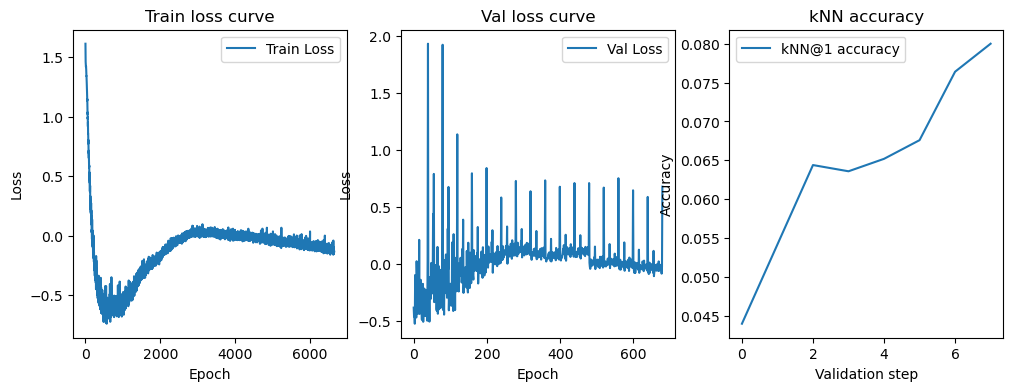

Epoch 18:   0%|          | 1/391 [00:01<09:27,  1.45s/it]

Epoch 18 Batch 0 Loss:-0.0935


Epoch 18:  13%|█▎        | 51/391 [00:27<02:57,  1.91it/s]

Epoch 18 Batch 50 Loss:-0.1000


Epoch 18:  26%|██▌       | 101/391 [00:54<02:31,  1.91it/s]

Epoch 18 Batch 100 Loss:-0.1353


Epoch 18:  39%|███▊      | 151/391 [01:20<02:05,  1.91it/s]

Epoch 18 Batch 150 Loss:-0.1224


Epoch 18:  51%|█████▏    | 201/391 [01:46<01:39,  1.91it/s]

Epoch 18 Batch 200 Loss:-0.1513


Epoch 18:  64%|██████▍   | 251/391 [02:12<01:13,  1.92it/s]

Epoch 18 Batch 250 Loss:-0.1425


Epoch 18:  77%|███████▋  | 301/391 [02:39<00:47,  1.89it/s]

Epoch 18 Batch 300 Loss:-0.1536


Epoch 18:  90%|████████▉ | 351/391 [03:05<00:21,  1.89it/s]

Epoch 18 Batch 350 Loss:-0.1288


Epoch 18: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


Validation kNN...
Epoch 18 kNN@1 accuracy: 8.12%


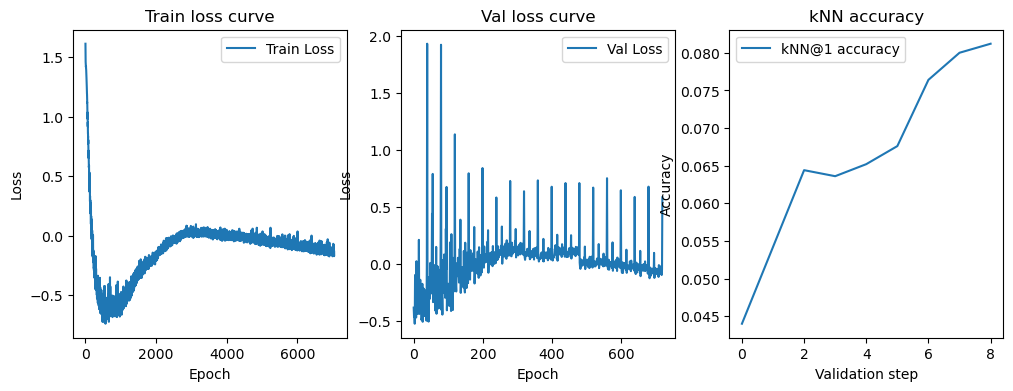

Epoch 19:   0%|          | 1/391 [00:01<08:53,  1.37s/it]

Epoch 19 Batch 0 Loss:-0.1316


Epoch 19:  13%|█▎        | 51/391 [00:27<02:58,  1.90it/s]

Epoch 19 Batch 50 Loss:-0.1449


Epoch 19:  26%|██▌       | 101/391 [00:53<02:31,  1.91it/s]

Epoch 19 Batch 100 Loss:-0.1625


Epoch 19:  90%|████████▉ | 351/391 [03:04<00:21,  1.90it/s]

Epoch 19 Batch 350 Loss:-0.1496


Epoch 19: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]


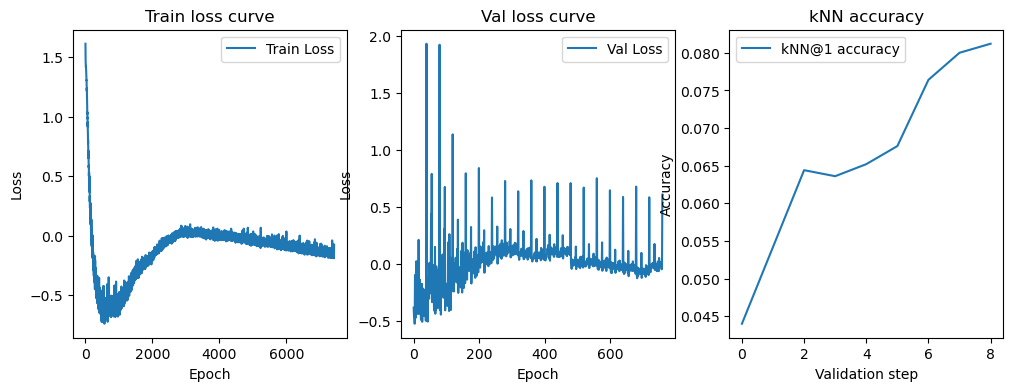

Epoch 20:   0%|          | 1/391 [00:01<08:38,  1.33s/it]

Epoch 20 Batch 0 Loss:-0.0911


Epoch 20:  13%|█▎        | 51/391 [00:27<03:00,  1.88it/s]

Epoch 20 Batch 50 Loss:-0.1898


Epoch 20:  26%|██▌       | 101/391 [00:54<02:33,  1.89it/s]

Epoch 20 Batch 100 Loss:-0.1783


Epoch 20:  39%|███▊      | 151/391 [01:20<02:06,  1.90it/s]

Epoch 20 Batch 150 Loss:-0.1459


Epoch 20:  51%|█████▏    | 201/391 [01:46<01:40,  1.89it/s]

Epoch 20 Batch 200 Loss:-0.1697


Epoch 27:  26%|██▌       | 101/391 [00:53<02:34,  1.88it/s]

Epoch 27 Batch 100 Loss:-0.2298


Epoch 27:  39%|███▊      | 151/391 [01:20<02:06,  1.89it/s]

Epoch 27 Batch 150 Loss:-0.2530


Epoch 30:  64%|██████▍   | 251/391 [02:12<01:12,  1.92it/s]

Epoch 30 Batch 250 Loss:-0.2837


Epoch 30:  77%|███████▋  | 301/391 [02:38<00:47,  1.90it/s]

Epoch 30 Batch 300 Loss:-0.2899


Epoch 30:  90%|████████▉ | 351/391 [03:05<00:20,  1.92it/s]

Epoch 30 Batch 350 Loss:-0.2860


Epoch 30: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]


Validation kNN...
Epoch 30 kNN@1 accuracy: 9.66%


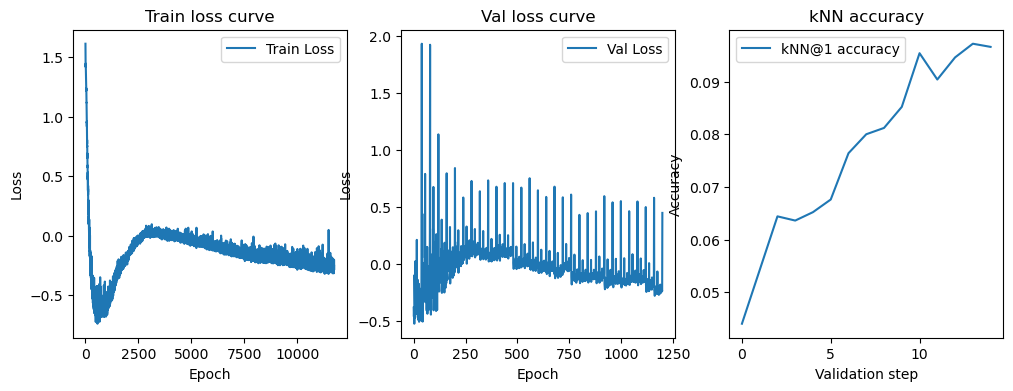

Epoch 31:   0%|          | 1/391 [00:01<07:14,  1.11s/it]

Epoch 31 Batch 0 Loss:-0.3112


Epoch 31:  13%|█▎        | 51/391 [00:27<02:58,  1.90it/s]

Epoch 31 Batch 50 Loss:-0.2602


Epoch 31:  26%|██▌       | 101/391 [00:53<02:33,  1.88it/s]

Epoch 31 Batch 100 Loss:-0.2500


Epoch 31:  39%|███▊      | 151/391 [01:20<02:06,  1.89it/s]

Epoch 31 Batch 150 Loss:-0.2862


Epoch 31:  51%|█████▏    | 201/391 [01:46<01:38,  1.92it/s]

Epoch 31 Batch 200 Loss:-0.2640


Epoch 31:  64%|██████▍   | 251/391 [02:12<01:13,  1.89it/s]

Epoch 31 Batch 250 Loss:-0.2487


Epoch 31:  77%|███████▋  | 301/391 [02:38<00:46,  1.93it/s]

Epoch 31 Batch 300 Loss:-0.2500


Epoch 31:  90%|████████▉ | 351/391 [03:05<00:20,  1.91it/s]

Epoch 31 Batch 350 Loss:-0.2758


Epoch 31: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]


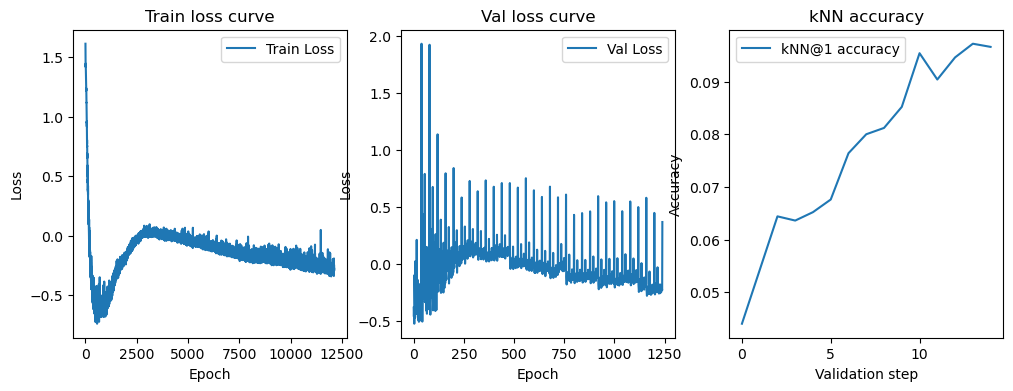

Epoch 32:   0%|          | 1/391 [00:01<09:21,  1.44s/it]

Epoch 32 Batch 0 Loss:-0.2985


Epoch 32:  13%|█▎        | 51/391 [00:27<02:59,  1.89it/s]

Epoch 32 Batch 50 Loss:-0.2979


Epoch 32:  26%|██▌       | 101/391 [00:54<02:34,  1.88it/s]

Epoch 32 Batch 100 Loss:-0.2955


Epoch 32:  39%|███▊      | 151/391 [01:20<02:07,  1.88it/s]

Epoch 32 Batch 150 Loss:-0.2774


Epoch 32:  51%|█████▏    | 201/391 [01:46<01:37,  1.94it/s]

Epoch 32 Batch 200 Loss:-0.2654


Epoch 32:  64%|██████▍   | 251/391 [02:12<01:14,  1.88it/s]

Epoch 32 Batch 250 Loss:-0.2766


Epoch 32:  77%|███████▋  | 301/391 [02:39<00:46,  1.94it/s]

Epoch 32 Batch 300 Loss:-0.3107


Epoch 32:  90%|████████▉ | 351/391 [03:05<00:20,  1.91it/s]

Epoch 32 Batch 350 Loss:-0.3278


Epoch 32: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


Validation kNN...
Epoch 32 kNN@1 accuracy: 9.78%


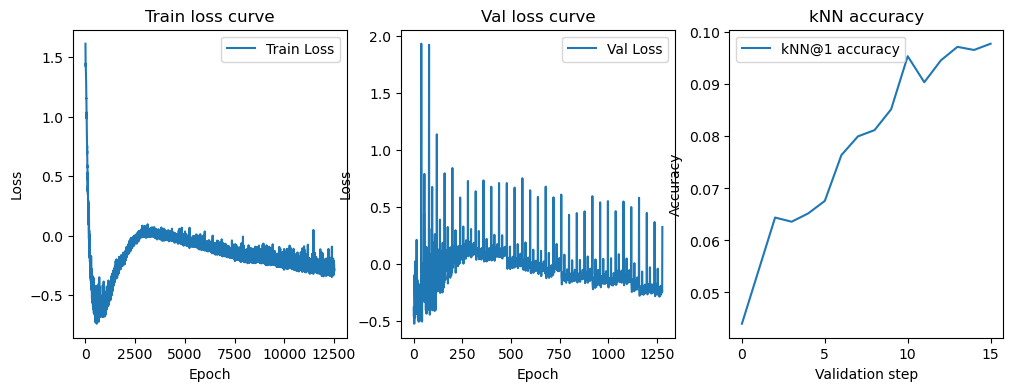

Epoch 33:   0%|          | 1/391 [00:01<09:03,  1.39s/it]

Epoch 33 Batch 0 Loss:-0.3161


Epoch 33:  13%|█▎        | 51/391 [00:27<02:58,  1.90it/s]

Epoch 33 Batch 50 Loss:-0.2954


Epoch 33:  26%|██▌       | 101/391 [00:54<02:33,  1.88it/s]

Epoch 33 Batch 100 Loss:-0.2968


Epoch 33:  39%|███▊      | 151/391 [01:20<02:04,  1.92it/s]

Epoch 33 Batch 150 Loss:-0.2436


Epoch 33:  51%|█████▏    | 201/391 [01:46<01:38,  1.92it/s]

Epoch 33 Batch 200 Loss:-0.3100


Epoch 33:  64%|██████▍   | 251/391 [02:12<01:14,  1.89it/s]

Epoch 33 Batch 250 Loss:-0.3090


Epoch 33:  77%|███████▋  | 301/391 [02:38<00:47,  1.91it/s]

Epoch 33 Batch 300 Loss:-0.2707


Epoch 33:  90%|████████▉ | 351/391 [03:05<00:20,  1.92it/s]

Epoch 33 Batch 350 Loss:-0.2861


Epoch 33: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]


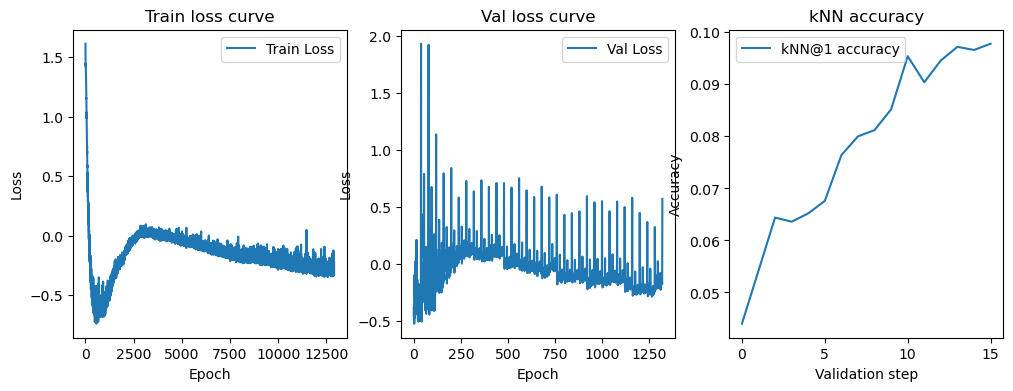

Epoch 34:   0%|          | 1/391 [00:01<08:31,  1.31s/it]

Epoch 34 Batch 0 Loss:-0.2572


Epoch 34:  13%|█▎        | 51/391 [00:27<02:59,  1.89it/s]

Epoch 34 Batch 50 Loss:-0.3266


Epoch 34:  26%|██▌       | 101/391 [00:53<02:32,  1.91it/s]

Epoch 34 Batch 100 Loss:-0.2733


Epoch 34:  39%|███▊      | 151/391 [01:20<02:06,  1.90it/s]

Epoch 34 Batch 150 Loss:-0.2891


Epoch 34:  51%|█████▏    | 201/391 [01:46<01:39,  1.91it/s]

Epoch 34 Batch 200 Loss:-0.3091


Epoch 34:  64%|██████▍   | 251/391 [02:12<01:12,  1.92it/s]

Epoch 34 Batch 250 Loss:-0.2799


Epoch 34:  77%|███████▋  | 301/391 [02:38<00:47,  1.91it/s]

Epoch 34 Batch 300 Loss:-0.3113


Epoch 34:  90%|████████▉ | 351/391 [03:04<00:20,  1.92it/s]

Epoch 34 Batch 350 Loss:-0.2399


Epoch 34: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]


Validation kNN...
Epoch 34 kNN@1 accuracy: 9.58%


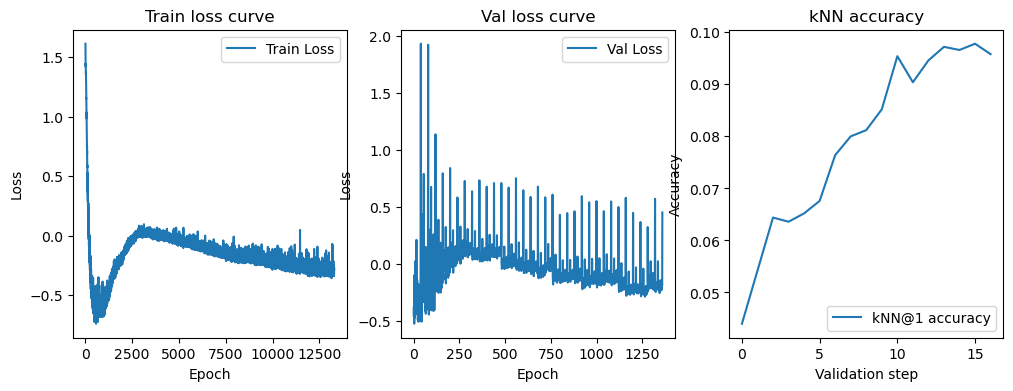

Epoch 35:   0%|          | 1/391 [00:01<08:07,  1.25s/it]

Epoch 35 Batch 0 Loss:-0.2815


Epoch 35:  13%|█▎        | 51/391 [00:27<02:57,  1.91it/s]

Epoch 35 Batch 50 Loss:-0.3367


Epoch 35:  26%|██▌       | 101/391 [00:53<02:32,  1.90it/s]

Epoch 35 Batch 100 Loss:-0.2992


Epoch 35:  39%|███▊      | 151/391 [01:20<02:05,  1.91it/s]

Epoch 35 Batch 150 Loss:-0.3050


Epoch 35:  51%|█████▏    | 201/391 [01:46<01:38,  1.93it/s]

Epoch 35 Batch 200 Loss:-0.2869


Epoch 35:  64%|██████▍   | 251/391 [02:12<01:14,  1.87it/s]

Epoch 35 Batch 250 Loss:-0.2561


Epoch 35:  77%|███████▋  | 301/391 [02:38<00:46,  1.92it/s]

Epoch 35 Batch 300 Loss:-0.2737


Epoch 35:  90%|████████▉ | 351/391 [03:05<00:20,  1.93it/s]

Epoch 35 Batch 350 Loss:-0.2955


Epoch 35: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]


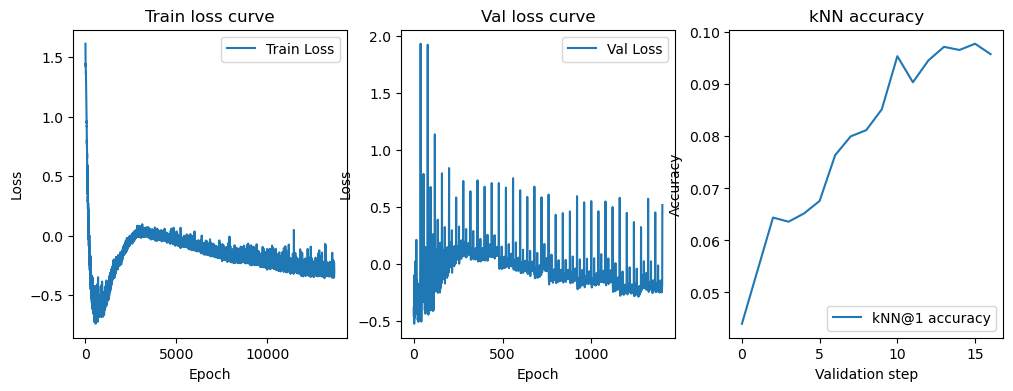

Epoch 36:   0%|          | 1/391 [00:01<09:31,  1.47s/it]

Epoch 36 Batch 0 Loss:-0.2776


Epoch 36:  13%|█▎        | 51/391 [00:27<02:58,  1.91it/s]

Epoch 36 Batch 50 Loss:-0.3169


Epoch 36:  26%|██▌       | 101/391 [00:53<02:31,  1.91it/s]

Epoch 36 Batch 100 Loss:-0.3400


Epoch 36:  39%|███▊      | 151/391 [01:20<02:05,  1.91it/s]

Epoch 36 Batch 150 Loss:-0.2976


Epoch 36:  51%|█████▏    | 201/391 [01:46<01:40,  1.89it/s]

Epoch 36 Batch 200 Loss:-0.2153


Epoch 36:  64%|██████▍   | 251/391 [02:12<01:13,  1.89it/s]

Epoch 36 Batch 250 Loss:-0.3363


Epoch 36:  77%|███████▋  | 301/391 [02:39<00:47,  1.89it/s]

Epoch 36 Batch 300 Loss:-0.3406


Epoch 36:  90%|████████▉ | 351/391 [03:05<00:21,  1.90it/s]

Epoch 36 Batch 350 Loss:-0.3212


Epoch 36: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


Validation kNN...
Epoch 36 kNN@1 accuracy: 10.44%


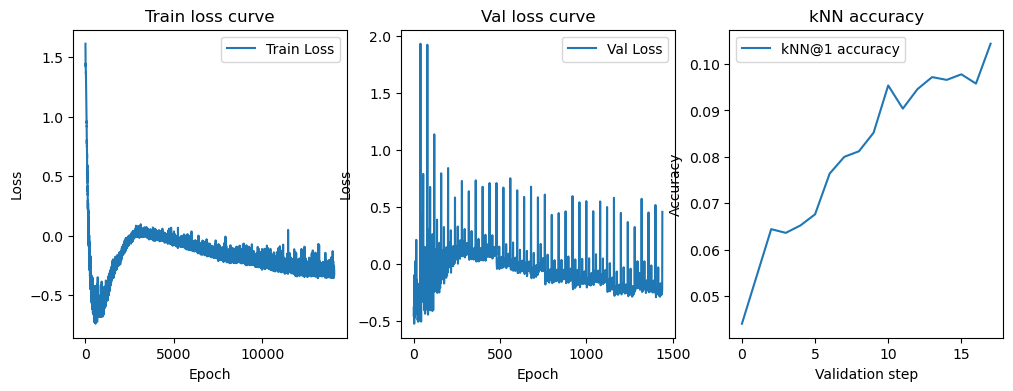

Epoch 37:   0%|          | 1/391 [00:01<08:39,  1.33s/it]

Epoch 37 Batch 0 Loss:-0.2990


Epoch 37:  13%|█▎        | 51/391 [00:27<02:57,  1.92it/s]

Epoch 37 Batch 50 Loss:-0.3342


Epoch 37:  26%|██▌       | 101/391 [00:53<02:31,  1.91it/s]

Epoch 37 Batch 100 Loss:-0.3351


Epoch 37:  39%|███▊      | 151/391 [01:20<02:06,  1.89it/s]

Epoch 37 Batch 150 Loss:-0.2968


Epoch 37:  51%|█████▏    | 201/391 [01:46<01:42,  1.86it/s]

Epoch 37 Batch 200 Loss:-0.3052


Epoch 37:  64%|██████▍   | 251/391 [02:12<01:13,  1.91it/s]

Epoch 37 Batch 250 Loss:-0.2971


Epoch 37:  77%|███████▋  | 301/391 [02:38<00:46,  1.93it/s]

Epoch 37 Batch 300 Loss:-0.2758


Epoch 37:  90%|████████▉ | 351/391 [03:05<00:21,  1.88it/s]

Epoch 37 Batch 350 Loss:-0.3284


Epoch 37: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]


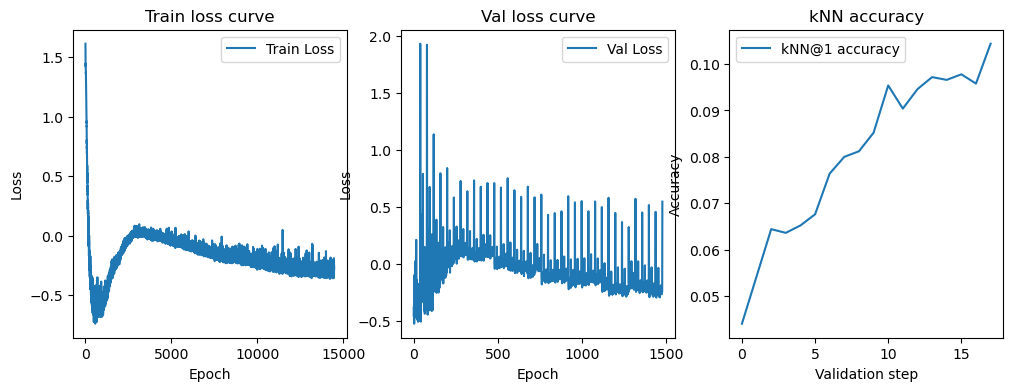

Epoch 38:   0%|          | 1/391 [00:01<08:13,  1.27s/it]

Epoch 38 Batch 0 Loss:-0.3063


Epoch 38:  13%|█▎        | 51/391 [00:27<02:59,  1.89it/s]

Epoch 38 Batch 50 Loss:-0.3534


Epoch 38:  26%|██▌       | 101/391 [00:54<02:34,  1.87it/s]

Epoch 38 Batch 100 Loss:-0.3312


Epoch 38:  39%|███▊      | 151/391 [01:20<02:04,  1.93it/s]

Epoch 38 Batch 150 Loss:-0.2907


Epoch 38:  51%|█████▏    | 201/391 [01:46<01:38,  1.92it/s]

Epoch 38 Batch 200 Loss:-0.2947


Epoch 38:  64%|██████▍   | 251/391 [02:12<01:14,  1.87it/s]

Epoch 38 Batch 250 Loss:-0.2404


Epoch 38:  77%|███████▋  | 301/391 [02:38<00:47,  1.89it/s]

Epoch 38 Batch 300 Loss:-0.3289


Epoch 38:  90%|████████▉ | 351/391 [03:05<00:21,  1.89it/s]

Epoch 38 Batch 350 Loss:-0.3119


Epoch 38: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


Validation kNN...
Epoch 38 kNN@1 accuracy: 10.02%


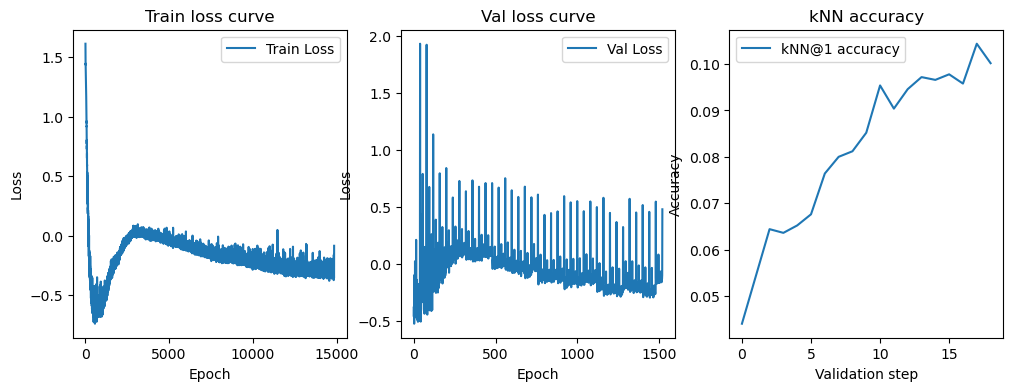

Epoch 39:   0%|          | 1/391 [00:01<07:51,  1.21s/it]

Epoch 39 Batch 0 Loss:-0.2281


Epoch 39:  13%|█▎        | 51/391 [00:27<02:59,  1.89it/s]

Epoch 39 Batch 50 Loss:-0.3066


Epoch 39:  26%|██▌       | 101/391 [00:54<02:31,  1.91it/s]

Epoch 39 Batch 100 Loss:-0.3127


Epoch 39:  39%|███▊      | 151/391 [01:20<02:07,  1.88it/s]

Epoch 39 Batch 150 Loss:-0.3253


Epoch 39:  51%|█████▏    | 201/391 [01:47<01:39,  1.90it/s]

Epoch 39 Batch 200 Loss:-0.3329


Epoch 39:  64%|██████▍   | 251/391 [02:13<01:14,  1.88it/s]

Epoch 39 Batch 250 Loss:-0.3135


Epoch 39:  77%|███████▋  | 301/391 [02:40<00:46,  1.92it/s]

Epoch 39 Batch 300 Loss:-0.2636


Epoch 39:  90%|████████▉ | 351/391 [03:06<00:21,  1.86it/s]

Epoch 39 Batch 350 Loss:-0.2906


Epoch 39: 100%|██████████| 391/391 [03:27<00:00,  1.88it/s]


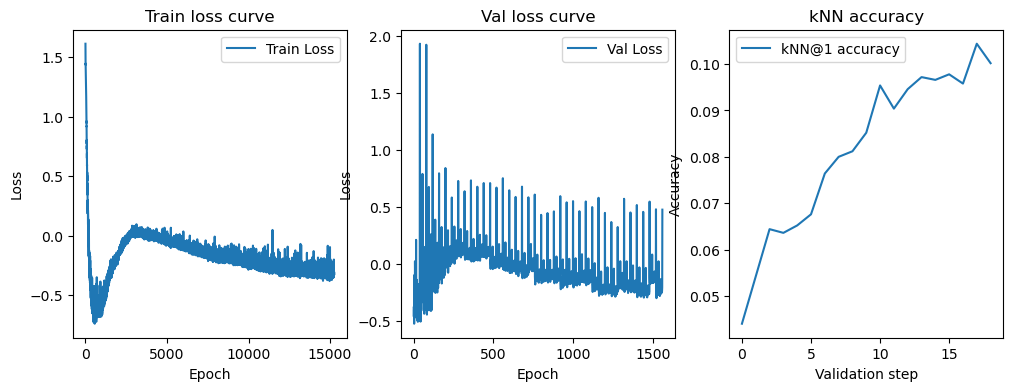

Epoch 40:   0%|          | 1/391 [00:01<08:54,  1.37s/it]

Epoch 40 Batch 0 Loss:-0.3145


Epoch 40:  13%|█▎        | 51/391 [00:27<02:59,  1.89it/s]

Epoch 40 Batch 50 Loss:-0.3325


Epoch 40:  26%|██▌       | 101/391 [00:53<02:31,  1.91it/s]

Epoch 40 Batch 100 Loss:-0.3121


Epoch 40:  39%|███▊      | 151/391 [01:20<02:05,  1.91it/s]

Epoch 40 Batch 150 Loss:-0.2881


Epoch 40:  51%|█████▏    | 201/391 [01:46<01:39,  1.91it/s]

Epoch 40 Batch 200 Loss:-0.3304


Epoch 40:  64%|██████▍   | 251/391 [02:12<01:14,  1.88it/s]

Epoch 40 Batch 250 Loss:-0.3334


Epoch 40:  77%|███████▋  | 301/391 [02:38<00:46,  1.92it/s]

Epoch 40 Batch 300 Loss:-0.2938


Epoch 40:  90%|████████▉ | 351/391 [03:05<00:20,  1.92it/s]

Epoch 40 Batch 350 Loss:-0.2776


Epoch 40: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]


Validation kNN...
Epoch 40 kNN@1 accuracy: 10.12%


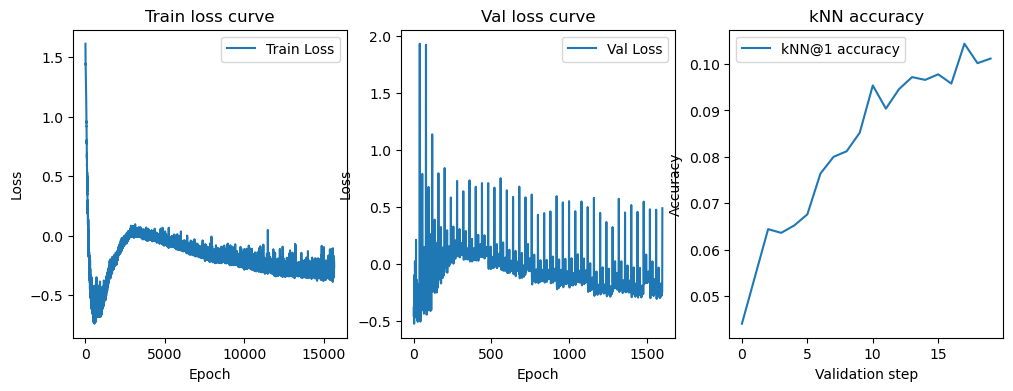

Epoch 41:   0%|          | 1/391 [00:01<08:24,  1.29s/it]

Epoch 41 Batch 0 Loss:-0.3553


Epoch 41:  13%|█▎        | 51/391 [00:27<02:59,  1.90it/s]

Epoch 41 Batch 50 Loss:-0.3275


Epoch 41:  26%|██▌       | 101/391 [00:54<02:31,  1.91it/s]

Epoch 41 Batch 100 Loss:-0.3435


Epoch 41:  39%|███▊      | 151/391 [01:20<02:05,  1.91it/s]

Epoch 41 Batch 150 Loss:-0.1879


Epoch 41:  51%|█████▏    | 201/391 [01:46<01:39,  1.91it/s]

Epoch 41 Batch 200 Loss:-0.2618


Epoch 41:  64%|██████▍   | 251/391 [02:12<01:13,  1.91it/s]

Epoch 41 Batch 250 Loss:-0.2645


Epoch 41:  77%|███████▋  | 301/391 [02:39<00:46,  1.92it/s]

Epoch 41 Batch 300 Loss:-0.3527


Epoch 41:  90%|████████▉ | 351/391 [03:05<00:20,  1.92it/s]

Epoch 41 Batch 350 Loss:-0.3282


Epoch 41: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


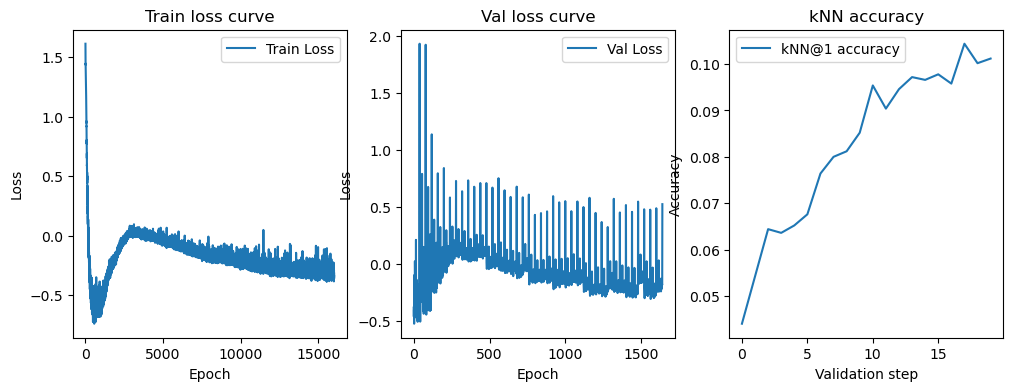

Epoch 42:   0%|          | 1/391 [00:01<08:52,  1.37s/it]

Epoch 42 Batch 0 Loss:-0.3065


Epoch 42:  13%|█▎        | 51/391 [00:27<03:01,  1.87it/s]

Epoch 42 Batch 50 Loss:-0.3250


Epoch 42:  26%|██▌       | 101/391 [00:54<02:37,  1.85it/s]

Epoch 42 Batch 100 Loss:-0.3466


Epoch 42:  39%|███▊      | 151/391 [01:21<02:07,  1.88it/s]

Epoch 42 Batch 150 Loss:-0.2493


Epoch 42:  51%|█████▏    | 201/391 [01:47<01:40,  1.89it/s]

Epoch 42 Batch 200 Loss:-0.3395


Epoch 42:  64%|██████▍   | 251/391 [02:13<01:13,  1.90it/s]

Epoch 42 Batch 250 Loss:-0.3261


Epoch 42:  77%|███████▋  | 301/391 [02:40<00:47,  1.90it/s]

Epoch 42 Batch 300 Loss:-0.3008


Epoch 42:  90%|████████▉ | 351/391 [03:07<00:21,  1.89it/s]

Epoch 42 Batch 350 Loss:-0.3356


Epoch 42: 100%|██████████| 391/391 [03:28<00:00,  1.88it/s]


Validation kNN...
Epoch 42 kNN@1 accuracy: 9.76%


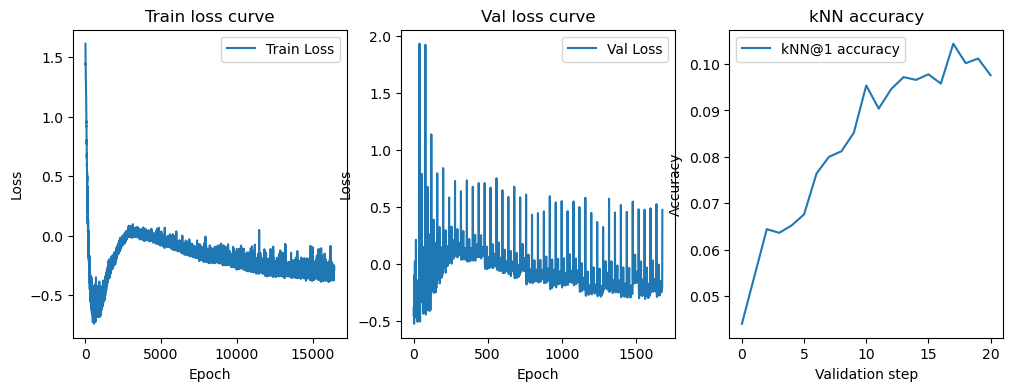

Epoch 43:   0%|          | 1/391 [00:01<07:53,  1.21s/it]

Epoch 43 Batch 0 Loss:-0.3202


Epoch 43:  13%|█▎        | 51/391 [00:27<02:54,  1.94it/s]

Epoch 43 Batch 50 Loss:-0.3442


Epoch 43:  26%|██▌       | 101/391 [00:53<02:32,  1.90it/s]

Epoch 43 Batch 100 Loss:-0.3076


Epoch 43:  39%|███▊      | 151/391 [01:19<02:05,  1.91it/s]

Epoch 43 Batch 150 Loss:-0.3381


Epoch 43:  51%|█████▏    | 201/391 [01:45<01:39,  1.92it/s]

Epoch 43 Batch 200 Loss:-0.3337


Epoch 43:  64%|██████▍   | 251/391 [02:12<01:14,  1.87it/s]

Epoch 43 Batch 250 Loss:-0.3167


Epoch 43:  77%|███████▋  | 301/391 [02:38<00:47,  1.90it/s]

Epoch 43 Batch 300 Loss:-0.3563


Epoch 43:  90%|████████▉ | 351/391 [03:04<00:21,  1.90it/s]

Epoch 43 Batch 350 Loss:-0.3269


Epoch 43: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]


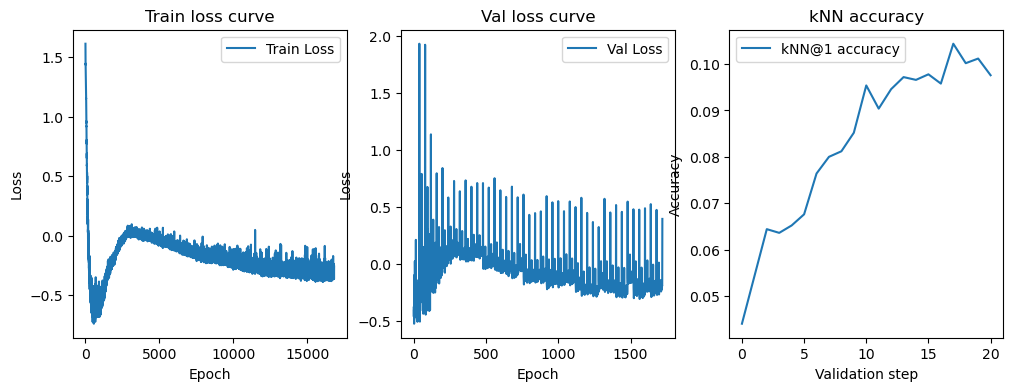

Epoch 44:   0%|          | 1/391 [00:01<09:07,  1.40s/it]

Epoch 44 Batch 0 Loss:-0.2888


Epoch 44:  13%|█▎        | 51/391 [00:27<02:58,  1.91it/s]

Epoch 44 Batch 50 Loss:-0.3125


Epoch 44:  26%|██▌       | 101/391 [00:54<02:30,  1.93it/s]

Epoch 44 Batch 100 Loss:-0.3434


Epoch 44:  30%|██▉       | 116/391 [01:02<02:25,  1.90it/s]

In [ ]:
train_losses = []
val_losses = []
knn_accuracies = []

for epoch in range(EPOCHS):
    student.train()
    predictor.train()
    epoch_loss = 0
    
    for batch_idx, (x, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        x = x.to(DEVICE)
        B = x.size(0)
        grid = student.backbone.grid
        ctx_list, tgt_list = [], []
        
        # Sample masks
        for b in range(B):
            ctx_mask, tgt_mask = sample_context_and_targets(grid)
            ctx_list.append(ctx_mask)
            tgt_list.append(tgt_mask)
        context_mask = torch.stack(ctx_list, dim=0).to(x.device)
        target_mask = torch.stack(tgt_list, dim=0).to(x.device)
        
        # --- Encode context with student ---
        ctx_out, ctx_pad = student.encode_context(x, context_mask)  # (B, Sc, D)
        ctx_mask_float = (~ctx_pad).float().unsqueeze(-1)
        ctx_sum = (ctx_out * ctx_mask_float).sum(dim=1)
        ctx_count = ctx_mask_float.sum(dim=1).clamp(min=1)
        ctx_feat = ctx_sum / ctx_count  # (B, D)
        
        # --- Teacher target embeddings ---
        with torch.no_grad():
            t_tokens = teacher(x)  # (B, T, D)
        
        tgt_idxs = [target_mask[i].nonzero(as_tuple=False).squeeze(1) for i in range(B)]
        St = int(max([int(idx.numel()) for idx in tgt_idxs]) if tgt_idxs else 0)
        D = t_tokens.size(2)
        
        teacher_tgt = torch.zeros(B, St, D, device=x.device, dtype=t_tokens.dtype)
        tgt_pad = torch.ones(B, St, dtype=torch.bool, device=x.device)
        for i, idx in enumerate(tgt_idxs):
            L = int(idx.numel())
            if L == 0: continue
            teacher_tgt[i, :L] = t_tokens[i, idx]
            tgt_pad[i, :L] = False
        
        teacher_tgt_flat = teacher_tgt[~tgt_pad].view(-1, D)  # (BSt, D)
        
        # Normalize targets (optional but recommended)
        mean_tgt = teacher_tgt_flat.mean(dim=0, keepdim=True)
        std_tgt = teacher_tgt_flat.std(dim=0, keepdim=True) + 1e-6
        teacher_tgt_flat = (teacher_tgt_flat - mean_tgt) / std_tgt
        
        # Expand context for each target token
        num_tgt = teacher_tgt_flat.size(0)
        ctx_feat_expanded = ctx_feat.unsqueeze(1).expand(B, St, -1).reshape(B * St, -1)[~tgt_pad.view(-1)]
        
        # --- Predict mixture params conditioned on context ---
        alpha, mu, sigma = predictor(teacher_tgt_flat, ctx_feat_expanded)
        
        # --- NLL loss + regularization ---
        loss = mixture_gaussian_nll_loss(teacher_tgt_flat, alpha, mu, sigma)
        
        # Regularize sigma
        log_sigma_mean = torch.log(sigma + 1e-8).mean()
        sigma_reg = 0.01 * (log_sigma_mean - math.log(0.1))**2
        loss = loss + sigma_reg
        
        epoch_loss += loss.item()
        
        # --- Backprop ---
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # EMA update teacher
        m = 0.996
        teacher.ema_update(student, m)
        
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1} Batch {batch_idx} Loss:{loss.item():.4f}")
        train_losses.append(loss.item())
    # avg_loss = epoch_loss / len(train_loader)
    # train_losses.append(avg_loss)
    
    val_loss_batches = eval_loss_on_loader(val_loader)
    val_losses.extend(val_loss_batches)
    
    # --- kNN Validation ---
    if (epoch + 1) % 2 == 0:
        print("Validation kNN...")
        tr_feats, tr_labels = extract_global_embeddings(student.backbone, train_loader, DEVICE)
        va_feats, va_labels = extract_global_embeddings(student.backbone, val_loader, DEVICE)
        knn_top1 = knn_eval(tr_feats, tr_labels, va_feats, va_labels, k=1)
        print(f"Epoch {epoch+1} kNN@1 accuracy: {knn_top1*100:.2f}%")
        
        knn_accuracies.append(knn_top1)
    
    # --- Plot ---
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train loss curve')
    plt.subplot(1,3,2)
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Val loss curve')
    plt.subplot(1,3,3)
    plt.plot(knn_accuracies, label='kNN@1 accuracy')
    plt.xlabel('Validation step')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('kNN accuracy')
    plt.show()

print("Training complete!")

In [ ]:
torch.save(student.state_dict(), "student_model.pth")
torch.save(predictor.state_dict(), "predictor_model.pth")
torch.save(teacher.state_dict(), "teacher_model.pth")